In [1]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [2]:
# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [3]:
tool.invoke("Langgraphのノードとは？")

[{'url': 'https://zenn.dev/pharmax/articles/8796b892eed183',
  'content': 'Nodeは、Graph上で実際のステップを実行するコンポーネントです。例えば実際にLangChainを使用してLLMのモデルを呼び出す処理は、Node上で行います。\n\nNodeでは、`(State、Config) -> 変更するState`というシグネチャを持つ関数を使うことができます。 [...] | コンポーネント | 説明 |\n| --- | --- |\n| Graph | LangGraphの中核となる構成要素で、各NodeとEdgeの集合体です。 |\n| State | ノード間の遷移の際に保持される情報で、各ノードが参照および更新します。 |\n| Node | グラフ内の個々のステップや状態を表す要素で、特定のアクションやチェックポイントとして機能します。 |\n| Edge | ノード間の接続を表し、遷移の条件やアクションを定義します。条件付きエッジなど、特定のロジックに基づいて遷移を制御できます。 |\n\n## Graph\n\nGraphは、LangGraphの中核となるグラフ全体を管理するためのコンポーネントです。基本的な使い方としては、`StateGraph`というクラスを使い、後述するStateとセットで初期化します。\n\n`StateGraph`\n\n（StateGraphの宣言例）'},
 {'url': 'https://qiita.com/sakuraia/items/27db3f118e0ee41c54c1',
  'content': '| 構成要素 | 説明 |\n| --- | --- |\n| State | グラフに共通する状態を管理する要素。ワークフローで実行される各Nodeによって更新された値を保存する。 |\n| Node | 処理を行う要素。Stateから必要な情報を取り出し、処理結果をもとにStateを更新する。 |\n| Edge | Node間を接続する要素。次に実行するノードを指定する。無条件に遷移するEdgeや条件に基づいて遷移先のNodeを決定する条件付きEdgeが設定できる。 |\n| Graph | NodeとEdgeで構成されるシス

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

In [5]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

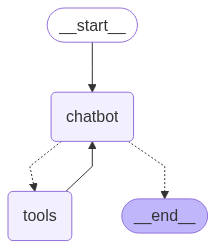

In [6]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！何かお手伝いできることがあれば教えてくださいね。
1足す2は？
1足す2は3です。ほかに何か質問がありますか？
1メートル以上の魚は？

[{"url": "https://tsurihack.com/8448", "content": "たとえ誰かに釣り場を案内してもらう時であっても、釣りたい魚がどんな環境で暮らしている生き物なのか図鑑や文献などで簡単にでも調べておくと良いですよ。\n\n### 諦めずに釣り場に通いましょう\n\n釣り\n\n釣り\n\n魚種やサイズによって大物釣りの難易度は、1日で釣れるものから数年かかるものまで様々です。\n\n自分が定めた目標に向かって、釣れない日や掛かってもバラしてしまう日だってあるかもしれませんが、諦めずに釣り場に通ってみましょう。\n\n手早く、狙った大物を釣り上げる腕利きの釣り人の方がカッコ良く見えるかもしれませんが、僕はたくさん努力したことで全身が震えるあの感動を味わえている人も素敵だなといつも感じます。\n\n## 近所に潜む大物10選＆レア度をご紹介\n\n### 大物は意外と身近にもいるんです\n\nそれでは、ここからは身近な水辺に生息する大物達を釣り上げる難易度別にご紹介していきます。\n\nどの魚も、陸っぱりで狙えて最大全長が1mを超えるものばかり！\n\nお住まいの地域にこれからリストアップする魚が生息していたら、狙ってみてはいかがでしょうか。\n\n## 鯉｜もっとも手軽で簡単な大物 [...] 怪魚ハンター山根ブラザーズの兄。\nテレビ東京・緊急SOS池の水全部抜くやNHK・ダーウィンが来た、TBS・VSリアルガチ危険生物などに出演したり、魚類生態調査に参加したりと幅広く活動中。\n初めての1匹との出会いに最も価値を置き、餌・ルアー・もはや釣りに限らず。ガサガサや漁業者と協力してまでも、まだ見ぬ生き物を追い求め、日々水辺に立っている。\n\n目次\n\n## 大物を釣る楽しさと魅力を語る\n\n### 魚の力強さを体感できる\n\n大物釣りの魅力、引きの強さ\n\n大物釣りの魅力、引きの強さ\n\n大物釣りの魅力のひとつに、魚達の力強さを一本の釣り糸を通して体感できることがあります。\n\nとくに1m、10kgを超えるような魚の重量感溢れるファイトで、身体が引っ張られるよう